In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
import csv

### Creating image datasets an data loaders for train and test using the experiments folder split

In [29]:
experiments_path = 'my_data/'
data_path = 'my_images/'
folder_names = ["with_mask_correct","with_mask_incorrect","without_mask"]

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [31]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [32]:
def create_data_files(experiments_path, data_path, train_percent):
    for folder in folder_names:
        print(os.listdir())
        images = [os.path.join(data_path+folder,f) for f in os.listdir(data_path+folder)]
        
        print("Number of images in {} = {}".format(data_path+folder,len(images)))
        #Write some images to the train folder
        with open(experiments_path+"/train.csv",'a') as file:
            for image in images[:round(len(images)*train_percent)]:
                shutil.copy(image,experiments_path +"/train" +"/"+ folder)

                
        #Write remaining images to test folder
        with open(experiments_path+"/test.csv",'a') as file:
            for image in images[round(len(images)*train_percent)+1:]:
                shutil.copy(image,experiments_path +"/test" +"/"+ folder)
                
    setup_csv_files(experiments_path,"train")
    setup_csv_files(experiments_path,"test")

In [33]:
def setup_csv_files(experiments_path, phase):
    with open(experiments_path+"/"+ phase +".csv",'w') as file:
        wr = csv.writer(file)
        wr.writerow(["filename","class"])
        for folder in folder_names:
            for image in os.listdir(os.path.join(experiments_path+"/"+ phase +"/"+folder)):
                wr.writerow([image,folder])

In [34]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    for folder in folder_names:
        train_dir_class = os.path.join(train_dir, folder)
        test_dir_class = os.path.join(test_dir, folder)
        os.makedirs(train_dir_class)
        os.makedirs(test_dir_class)
    
    create_data_files(experiments_path, data_path, 0.8)

X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [35]:
# TEMPORARY, for adding in a temporary larger test set

#setup_csv_files(experiments_path,"test")
#setup_csv_files(experiments_path,"train")

In [36]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [37]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 390
    Root location: my_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [38]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 95
    Root location: my_data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [39]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [40]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f13139ba670>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f13139ba4f0>}

In [41]:
class_names = image_datasets['train'].classes

In [42]:
class_names

['with_mask_correct', 'with_mask_incorrect', 'without_mask']

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
device

device(type='cuda', index=0)

In [45]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


### Visualizing images

In [46]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [47]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

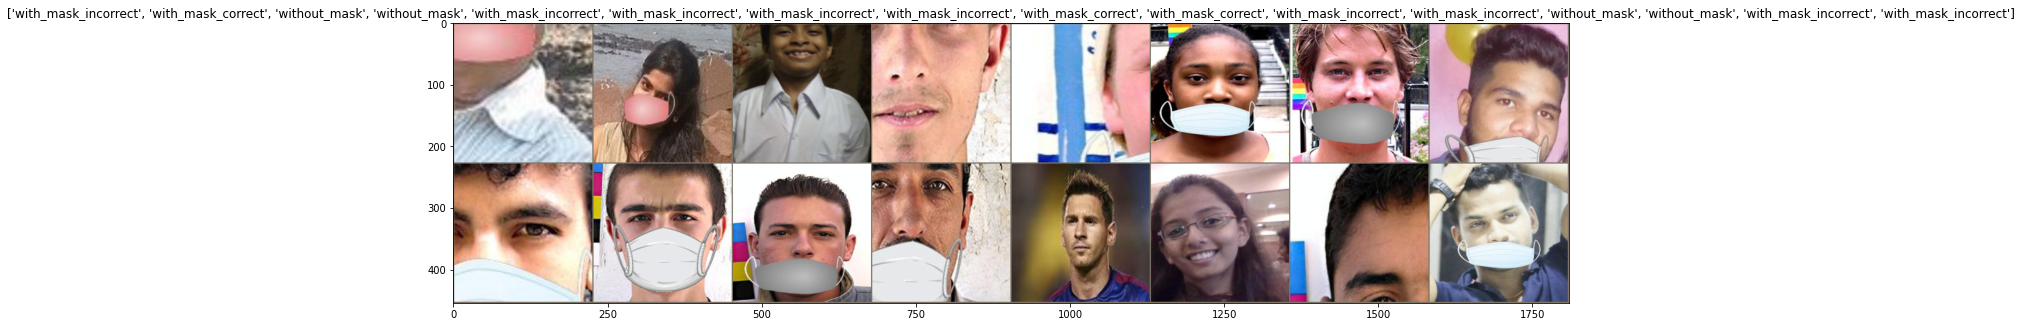

In [48]:
imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    loss_hist = []
    acc_hist = []

    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_hist.append(float(epoch_loss))
            acc_hist.append(float(epoch_acc))
            
            #print('Epoch {}/{} Loss: {:.4f} Acc:{:.4f}'.format(
            #    epoch, num_epochs - 1, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model,{'acc': acc_hist,'loss': loss_hist}
                

In [50]:
def get_accuracy(model_ft, num_images):
    device = torch.device("cpu")
    model_ft.to(device)
    model_ft.eval()
    total_correct = 0
    total_tested = 0

    incorrect_images = []
    images_shown = 0
    for inputs,labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for i,pred in enumerate(preds):
            if(pred != labels[i] and images_shown < num_images):
                images_shown += 1
                incorrect_images.append(inputs[i])

                imshow(inputs[i],"Predicted: {} Actual: {}".format(class_names[pred],class_names[labels[i]]))
        total_correct += torch.sum(preds == labels.data)
        total_tested += len(inputs.data)

    print("Test acc: {} ({}/{})".format(float(total_correct)/float(total_tested),total_correct,total_tested))

In [51]:
vgg11 = models.vgg11(pretrained=True)
num_frts = vgg11.classifier[6].in_features
vgg11.classifier[6] = nn.Linear(num_frts, len(class_names))

resnet101 = models.resnet101(pretrained=True)
num_frts = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_frts,len(class_names))

my_models = [vgg11, resnet101]

for model_ft in my_models:
    name = type(model_ft).__name__
    print("Training with "+name)

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()

    #optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft,history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

    get_accuracy(model_ft,0)
    
    torch.save(model_ft,name)

    plt.plot(np.linspace(1,len(history['acc']),len(history['acc'])),history['acc'],label = name)

plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
    

Training with VGG


/home/graham/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training complete in 1.000000m 21s
Best val acc: 0.989474
Test acc: 0.9894736842105263 (94/95)
Training with ResNet


/home/graham/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training complete in 2.000000m 15s
Best val acc: 1.000000


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

if(False):
    model_ft = torch.load('mask1_model_resnet101.pth')